In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Variables
r_ball_m = 0.1066       # [m]
m_ball_kg = 0.28        # [kg]
rho_h20_kgpm3 = 997     # [kg/m^3]
coeff_drag_ball = 0.5        # [unitless]

# Constants
g = 9.81                            # [m/s^2]
depth_ball_start_m = r_ball_m            # [m]

# Derived values
cross_section_area_ball_m2 = np.pi*np.power(r_ball_m, 2)
volume_ball_m3 = (4/3)*np.pi*np.power(r_ball_m, 3)

force_buoyancy_N = rho_h20_kgpm3 * g * volume_ball_m3
force_g_N = m_ball_kg * g

In [3]:
start_time_point_sec = 0    # [sec]
end_time_point_sec = 0.1    # [sec]
number_of_time_points = 10000
time_points_sec = np.linspace(start_time_point_sec, end_time_point_sec, number_of_time_points)
delta_time_sec = time_points_sec[1] - time_points_sec[0]

volume_ball_values_m3 = np.zeros_like(time_points_sec)
cross_section_area_ball_values_m2 = np.zeros_like(time_points_sec)

velocity_values_mps = np.zeros_like(time_points_sec)
acceleration_values_mps2 = np.zeros_like(time_points_sec)
depth_values_ball_m = np.zeros_like(time_points_sec)
force_net_values_N = np.zeros_like(time_points_sec)
force_buoyancy_values_N = np.zeros_like(time_points_sec)

In [4]:
def calculate_velocity_mps(acceleration_mps2, delta_time_sec):
    return acceleration_mps2 * delta_time_sec

def calculate_position_m(velocity_mps, delta_time_sec):
    return velocity_mps * delta_time_sec

def calculate_force_drag_N(rho_kgpm3, velocity_mps, coeff_drag, reference_area_m2):
    '''
    Calculates the drag force. 
    '''
    return (1/2) * rho_kgpm3 * np.power(velocity_mps, 2) * coeff_drag * reference_area_m2

def calculate_force_net_N(time_point, velocity_value_mps):
    # No initial velocity, therefore no drag force at initial time (assumption)
    if time_point == 0.0: 
        return force_buoyancy_N - force_g_N

    force_drag_N = calculate_force_drag_N(rho_h20_kgpm3, velocity_value_mps, coeff_drag_ball, cross_section_area_ball_m2)
    return force_buoyancy_N - (force_g_N + force_drag_N)

def calculate_acceleration_mps2(force_net_N, mass_kg):
    '''
    Calculates the acceleration based on F=ma equation. 
    '''
    return force_net_N/mass_kg

def calculate_volume_ball_submerged(radius_ball_m, midpoint_depth_m):
    '''
    Calculates the volume of the ball that is submerged underwater. 
    '''

    if midpoint_depth_m > radius_ball_m:
        midpoint_depth_m = radius_ball_m

    number_of_ball_length_points = 10000
    ball_length_values = np.linspace(-radius_ball_m, midpoint_depth_m, number_of_ball_length_points)
    delta_ball_length_points = ball_length_values[1] - ball_length_values[0]
    
    volume_ball_integrand = np.pi * (np.power(radius_ball_m, 2) - np.power(ball_length_values, 2))

    return np.sum(volume_ball_integrand) * delta_ball_length_points

def calculate_frontal_area_ball_submerged(radius_ball_m, midpoint_depth_m):
    '''
    Calculates the frontal area of the ball that is submerged underwater. 
    '''
    if midpoint_depth_m >= 0:
        return np.pi*np.power(radius_ball_m, 2)
    elif midpoint_depth_m < 0:
        return np.pi*(np.power(radius_ball_m, 2) - np.power(midpoint_depth_m, 2))

In [7]:
for i in range(0, len(time_points_sec)):
    
    # Assuming initial values 
    velocity_ball_mps = 0.0 
    depth_ball_current_m = depth_ball_start_m

    if i > 0:
        velocity_ball_mps = calculate_velocity_mps(acceleration_values_mps2[i-1], delta_time_sec) + velocity_values_mps[i-1]
        depth_ball_current_m = -1 * calculate_position_m(velocity_values_mps[i-1], delta_time_sec) + depth_values_ball_m[i-1]
    
    velocity_values_mps[i] = velocity_ball_mps
    volume_ball_values_m3[i] = calculate_volume_ball_submerged(r_ball_m, depth_ball_current_m)
    cross_section_area_ball_values_m2[i] = calculate_frontal_area_ball_submerged(r_ball_m, depth_ball_current_m)
    depth_values_ball_m[i] = depth_ball_current_m

    force_net_N = calculate_force_net_N(time_points_sec[i], velocity_ball_mps)
    force_net_values_N[i] = force_net_N

    acceleration_ball_mps2 = calculate_acceleration_mps2(force_net_N, m_ball_kg)
    acceleration_values_mps2[i] = acceleration_ball_mps2 

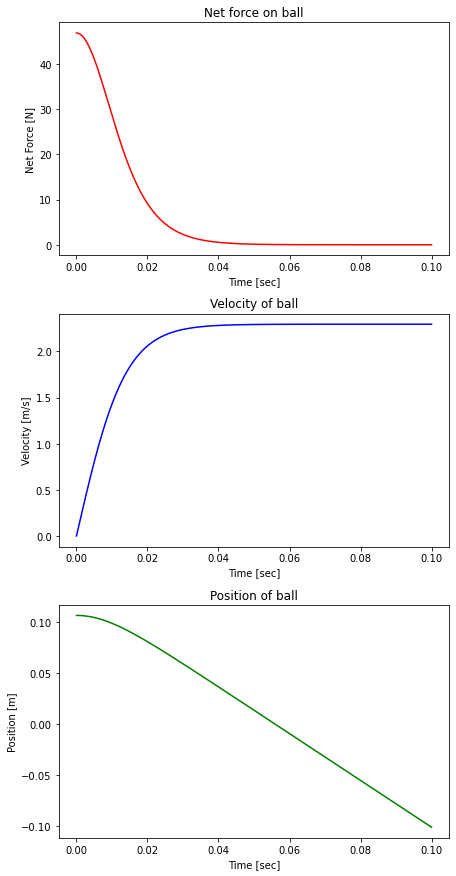

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(7, 15))

axs[0].plot(time_points_sec, force_net_values_N, color="red")
axs[0].set(title="Net force on ball", 
           xlabel="Time [sec]", 
           ylabel="Net Force [N]")

axs[1].plot(time_points_sec, velocity_values_mps, color='blue')
axs[1].set(title="Velocity of ball",
           xlabel="Time [sec]",
           ylabel="Velocity [m/s]")

axs[2].plot(time_points_sec, depth_values_ball_m, color='green')
axs[2].set(title="Position of ball",
           xlabel="Time [sec]",
           ylabel="Position [m]")

plt.subplots_adjust(wspace=0.25, hspace=0.25)


### Determining behavior at terminal velocity

In [ ]:
# Determining terminal velocity of ball underwater 
v_ball_mps_numerator = 2*(force_buoyancy_N - force_g_N)
v_ball_mps_denominator = rho_h20_kgpm3*coeff_drag*np.pi*np.power(r_ball_m, 2)
v_ball_mps = np.sqrt(v_ball_mps_numerator/v_ball_mps_denominator)
v_ball_mps_string = "{:.3f}".format(v_ball_mps)

print("Terminal velocity of ball: " + v_ball_mps_string + " m/s")

### Questions and miscellaneous thoughts
1. How much do we need to account for surface tension? Based on research, because the object is big, and the effects of other forces play a greater role, surface tension might not come into play. However, based on experimenting with submerging the ball, if the ball is submerged deep enough, the ball won't be "launched." Rather, it will come up to the surface with a layer of water on it, and soon the water will "fall off." I believe that this is the surface tension that is acting on the ball because when the net force on the ball is zero from the other forces, the surface tension could be big enough that it would push the ball down or keep it submerged for as long as it can. 